In [1]:
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import sys
import os

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = torch.device('cpu')

# torch.set_num_threads(1)
# torch.set_num_interop_threads(1)

# Presence / absence

## Simulate data

In [120]:
import numpy as np
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

np.random.seed(123456)
nsite, nrep, n_sp, n_occ_var, n_det_var = 200, 10, 10, 2, 2

# Env data
x = np.random.normal(-1, 2, size=(nsite, n_occ_var)).astype('float32').reshape(nsite,n_occ_var )

# Effort data
effort = np.random.uniform(-1, 1, size=(nsite, nrep, n_occ_var)).astype(np.float32) # (n_site,n_rep, n_det_var)

# process model
process_coef = np.random.normal(0, 1, size=(n_occ_var, n_sp))
latent_z = x @ process_coef

# latent occupancy probability
psi = 1 / (1 + np.exp(-(latent_z)))  # site‐level occupancy prob

# Species interaction at occupancy level
gamma = np.random.normal(loc=-0.05, scale=0.2, size=(n_sp, n_sp)) # species interaction
np.fill_diagonal(gamma, 0.0)
# L = (psi[:,:,np.newaxis] * gamma[np.newaxis, :, :]).sum(axis=-1)
L = psi @ gamma
delta = np.exp(L)
psi = np.clip(psi * delta, 0, 1)

occ = np.random.binomial(1, psi)     # true occupancy

# observation model
observation_coef = np.random.normal(0, 0.5, size=(n_occ_var + n_det_var, n_sp))

logit_p = (0
           + np.concatenate([np.repeat(np.expand_dims(x, -2), nrep, axis=-2),
                effort], axis=-1) @ observation_coef
           ) # effect of effort on detection
p = 1 / (1 + np.exp(-logit_p))       # (nsite, nrep)

# Combined observation results
y = np.random.binomial(n=np.repeat(np.expand_dims(occ, axis=-2), nrep, axis=-2), p=p)  # (nsite, nrep)


## Plot relationships

### Vars vs. occupancy probability

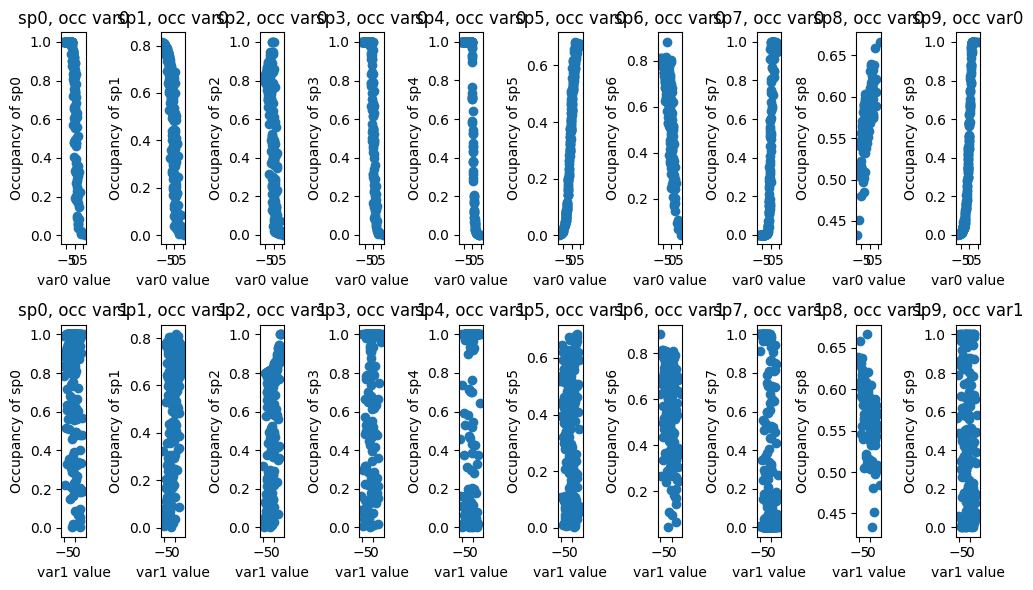

In [121]:
fig, ax = plt.subplots(n_occ_var, n_sp, figsize=(10, 6))
for occ_var_idx in range(x.shape[1]):
    for sp_idx in range(n_sp):
        ax[occ_var_idx, sp_idx].scatter(x[:,occ_var_idx], psi[:,sp_idx])
        ax[occ_var_idx, sp_idx].set_title(f'sp{sp_idx}, occ var{occ_var_idx}')
        ax[occ_var_idx, sp_idx].set_xlabel(f'var{occ_var_idx} value')
        ax[occ_var_idx, sp_idx].set_ylabel(f'Occupancy of sp{sp_idx}')

plt.tight_layout()
plt.show()

### Vars vs. detection probability

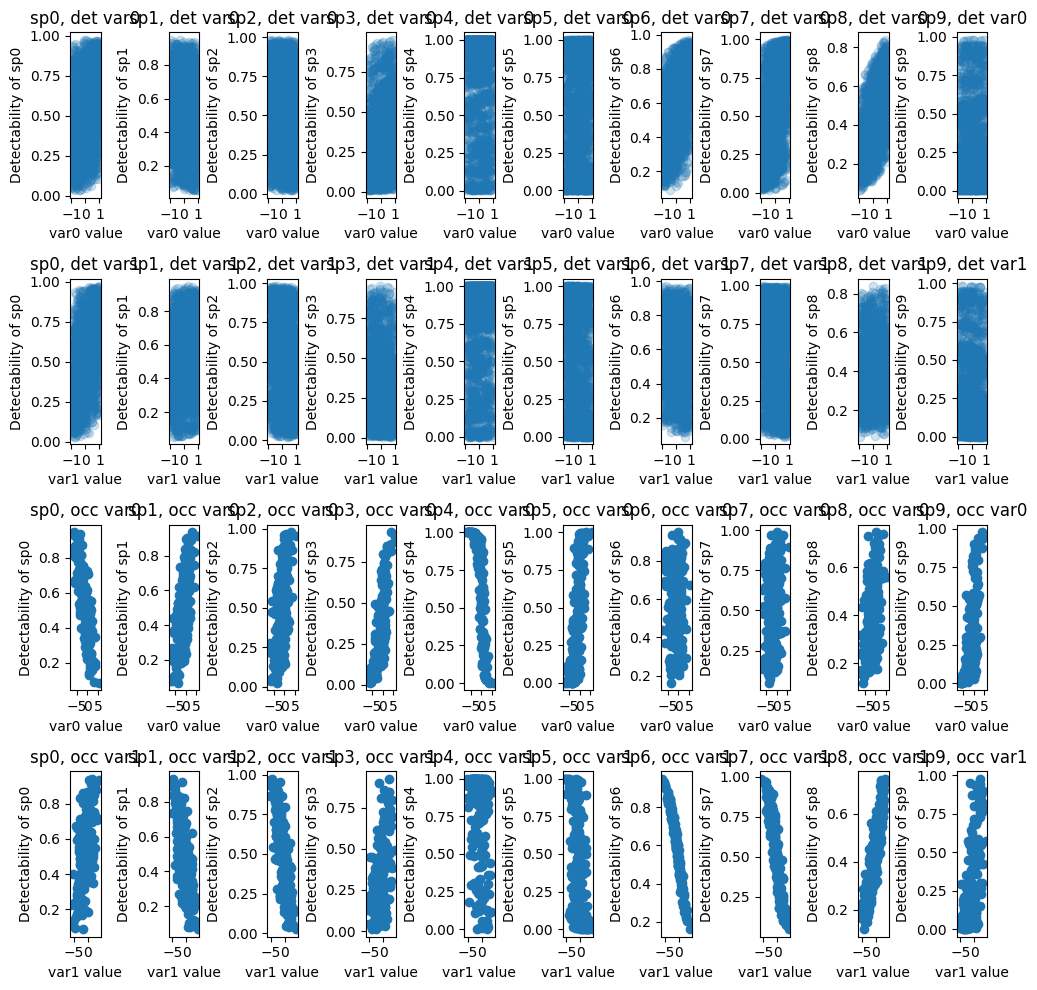

In [122]:
fig, ax = plt.subplots(n_det_var + n_occ_var, n_sp, figsize=(10, 10))
for var_idx in range(effort.shape[-1]):
    for sp_idx in range(n_sp):
        ax[var_idx, sp_idx].scatter(effort[...,var_idx].flatten(), p[...,sp_idx].flatten(), alpha=0.2)
        ax[var_idx, sp_idx].set_title(f'sp{sp_idx}, det var{var_idx}')
        ax[var_idx, sp_idx].set_xlabel(f'var{var_idx} value')
        ax[var_idx, sp_idx].set_ylabel(f'Detectability of sp{sp_idx}')

for var_idx in range(x.shape[-1]):
    for sp_idx in range(n_sp):
        ax[var_idx + effort.shape[-1], sp_idx].scatter(x[...,var_idx].flatten(), p[...,sp_idx].mean(axis=-1))
        ax[var_idx + effort.shape[-1], sp_idx].set_title(f'sp{sp_idx}, occ var{var_idx}')
        ax[var_idx + effort.shape[-1], sp_idx].set_xlabel(f'var{var_idx} value')
        ax[var_idx + effort.shape[-1], sp_idx].set_ylabel(f'Detectability of sp{sp_idx}')
        
plt.tight_layout()
plt.show()


### Env var vs. Y observed

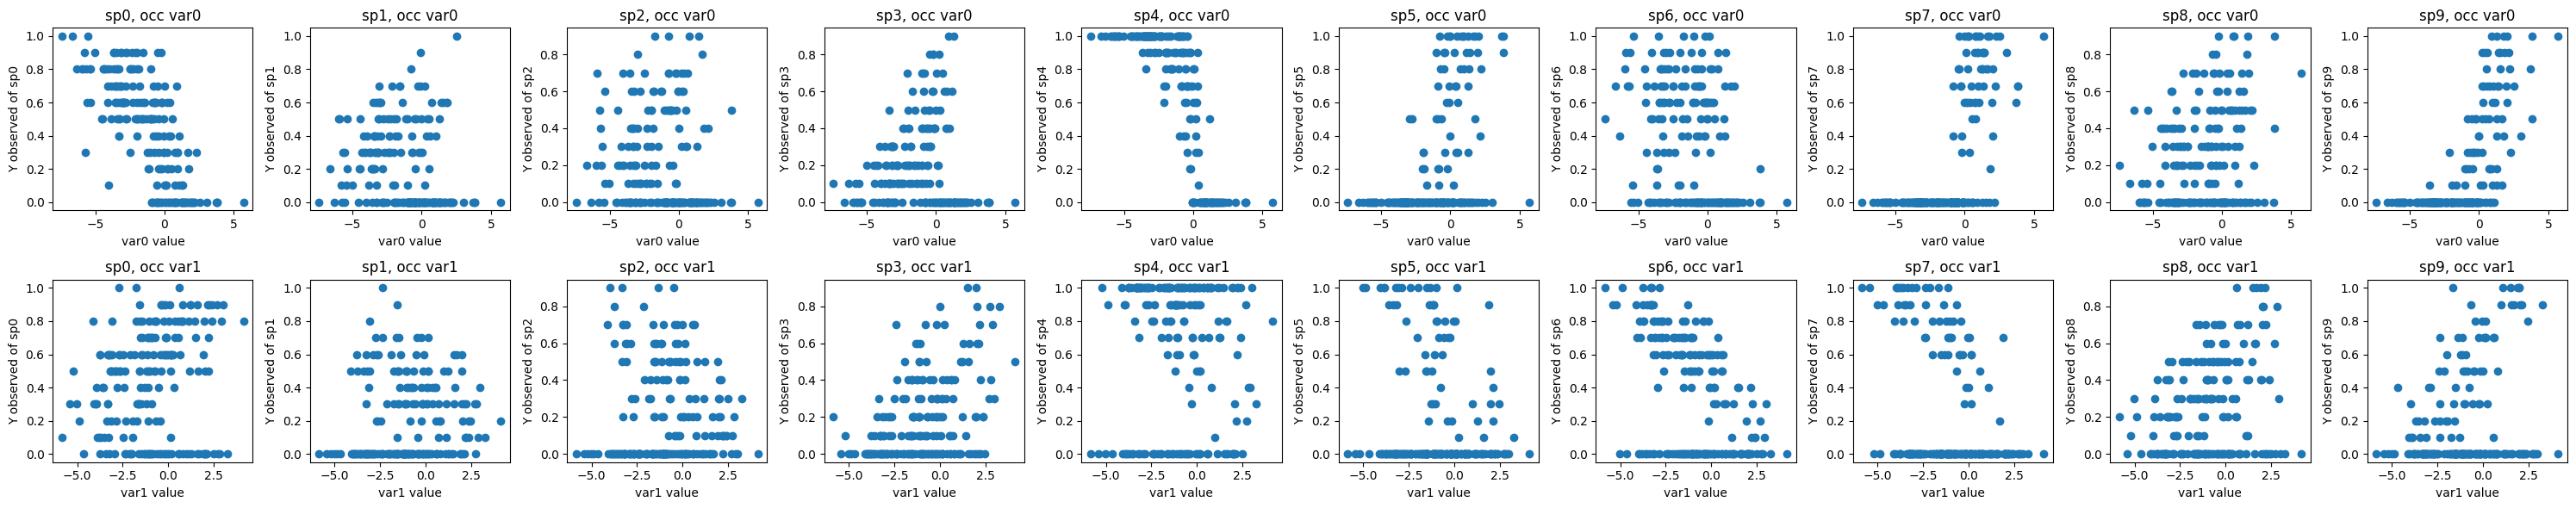

In [123]:
fig, ax = plt.subplots(n_occ_var, n_sp, figsize=(3*n_sp, 3*n_occ_var))
for occ_var_idx in range(x.shape[1]):
    for sp_idx in range(n_sp):
        ax[occ_var_idx, sp_idx].scatter(x[:,occ_var_idx], y[...,sp_idx].mean(axis=-1))
        ax[occ_var_idx, sp_idx].set_title(f'sp{sp_idx}, occ var{occ_var_idx}')
        ax[occ_var_idx, sp_idx].set_xlabel(f'var{occ_var_idx} value')
        ax[occ_var_idx, sp_idx].set_ylabel(f'Y observed of sp{sp_idx}')

plt.tight_layout()
plt.show()

### Env vs. True occupancy

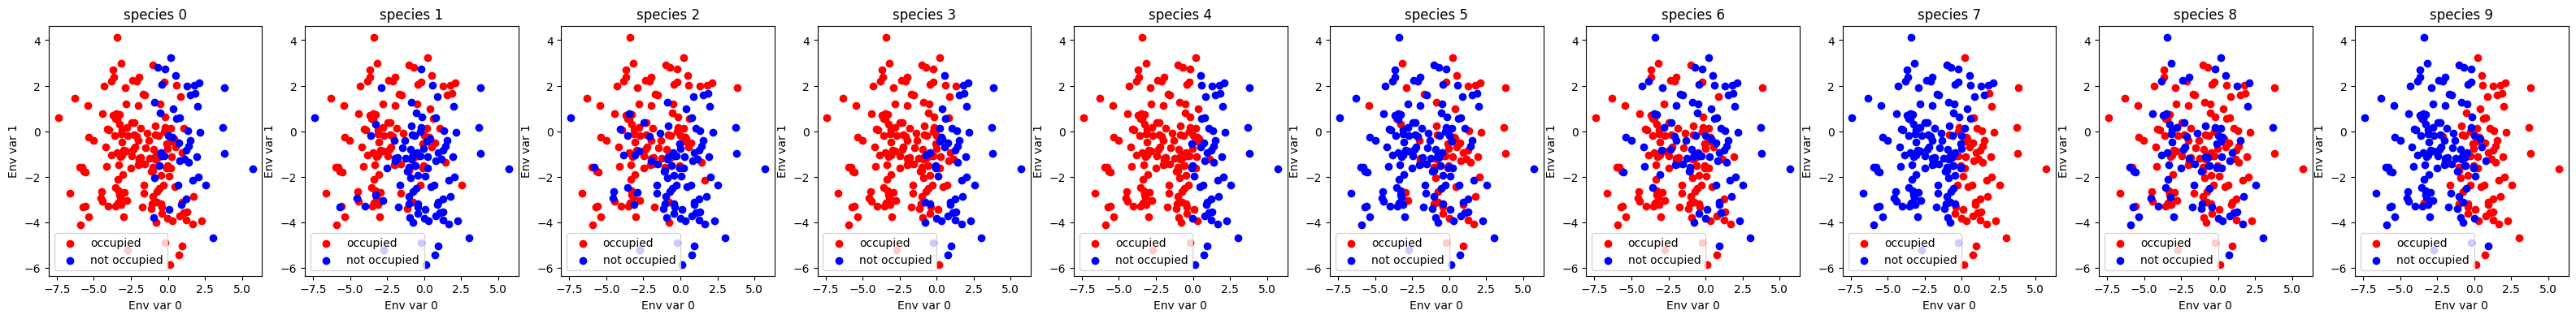

In [124]:
fig, ax = plt.subplots(1, n_sp, figsize=(4*n_sp, 4))
for sp in range(n_sp):
    ax[sp].scatter(x[:,0][occ[:,sp]==1], x[:,1][occ[:,sp]==1], label='occupied', color='red')
    ax[sp].scatter(x[:,0][occ[:,sp]==0], x[:,1][occ[:,sp]==0], label='not occupied', color='blue')
    ax[sp].legend()
    ax[sp].set_title(f'species {sp}')
    ax[sp].set_xlabel('Env var 0')
    ax[sp].set_ylabel('Env var 1')

plt.show()


### Env vs. Observed result

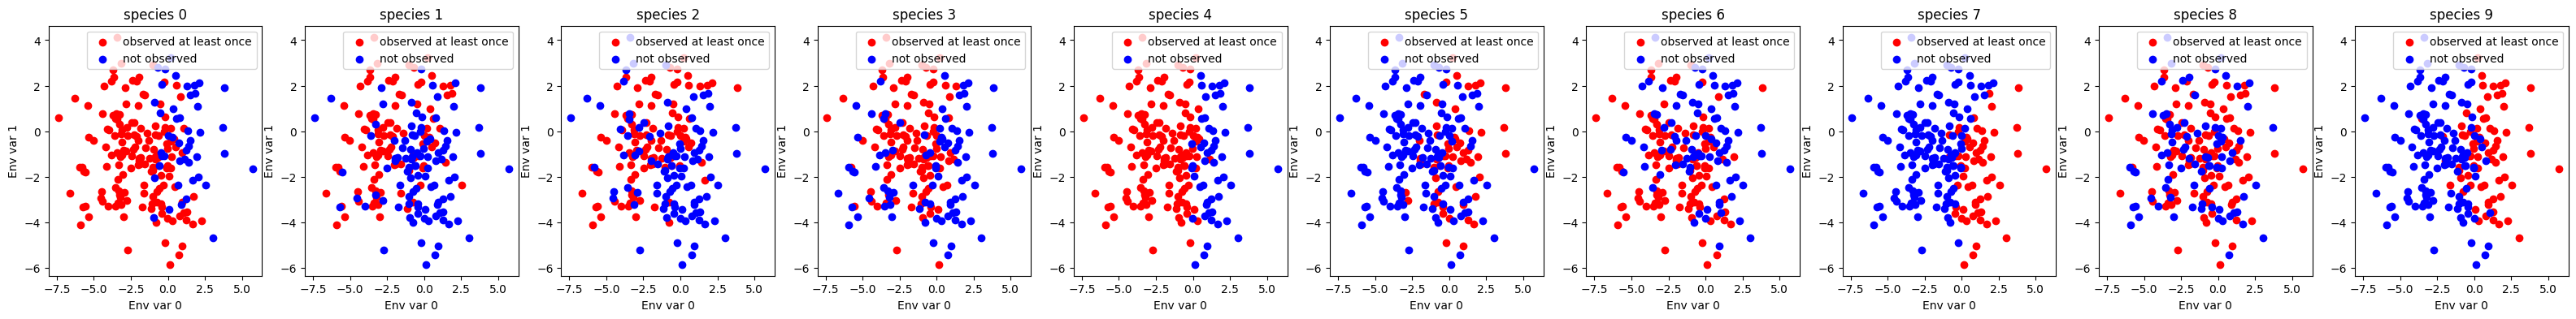

In [125]:
fig, ax = plt.subplots(1, n_sp, figsize=(4*n_sp, 4))
for sp in range(n_sp):
    must_occupied = (y[...,sp]).mean(axis=-1)>0
    not_observed = (y[...,sp]).mean(axis=-1)==0
    ax[sp].scatter(x[:,0][must_occupied], x[:,1][must_occupied], label='observed at least once', color='red')
    ax[sp].scatter(x[:,0][not_observed], x[:,1][not_observed], label='not observed', color='blue')
    ax[sp].legend()
    ax[sp].set_title(f'species {sp}')
    ax[sp].set_xlabel('Env var 0')
    ax[sp].set_ylabel('Env var 1')

plt.show()


## Make the data into dataframe

In [126]:
y_with_missing = y.copy()
y_with_missing[np.random.random(size=y_with_missing.shape) < 0.3]= -1


In [127]:
df = pd.DataFrame(
    y_with_missing.reshape(nsite * nrep, n_sp),
    columns=[f"sp{i}" for i in range(n_sp)]
)
df["site"] = np.repeat(np.arange(nsite), nrep)
df["checklist_id"] = np.tile( np.arange(nrep), nsite)

occ_var_df = pd.DataFrame(x, columns=['occ_var0', 'occ_var1'], index=pd.Index([i for i in range(nsite)], name='site')).reset_index(drop=False)
for i in range(n_sp):
    occ_var_df[f'true_occ_sp{i}'] = occ[:,i]
det_var_df = pd.DataFrame(effort.reshape(nsite * nrep, n_det_var), columns=[f'det_var{i}' for i in range(n_det_var)])

df = df.merge(occ_var_df, left_on='site', right_on='site', how='left')
for i in range(n_det_var):
    df[f'det_var{i}'] = det_var_df[f'det_var{i}'].values
    
for i in range(n_sp):
    df[f'true_det_sp{i}'] = p[...,i].reshape(nsite * nrep)

df['checklist_unique_id'] = list(df.index)


## Transform the df to PyG dataset

In [128]:
df


,sp0,sp1,sp2,sp3,sp4,sp5,sp6,sp7,sp8,sp9,...,true_det_sp1,true_det_sp2,true_det_sp3,true_det_sp4,true_det_sp5,true_det_sp6,true_det_sp7,true_det_sp8,true_det_sp9,checklist_unique_id
0,0,1,1,1,1,0,1,-1,-1,0,...,0.660187,0.682316,0.333461,0.722612,0.774280,0.648203,0.705912,0.378114,0.248252,0
1,0,-1,1,0,-1,0,1,0,0,0,...,0.622475,0.711947,0.367091,0.715705,0.820200,0.693954,0.773203,0.393475,0.275491,1
2,1,-1,-1,-1,-1,0,0,0,-1,0,...,0.706525,0.684614,0.268018,0.715722,0.715892,0.524508,0.496394,0.291246,0.219567,2
3,1,-1,1,0,1,0,-1,0,0,0,...,0.642006,0.627263,0.394336,0.744144,0.780488,0.750545,0.850824,0.507045,0.253903,3
4,-1,-1,1,-1,-1,0,1,0,0,-1,...,0.645402,0.597759,0.407554,0.753254,0.769571,0.772393,0.876269,0.549572,0.248901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,-1,-1,-1,-1,0,0,-1,-1,0,...,0.588256,0.561542,0.089084,0.995981,0.432673,0.855704,0.902029,0.333067,0.020018,1995
1996,0,0,1,-1,1,0,0,-1,0,-1,...,0.556728,0.750992,0.065034,0.994420,0.549695,0.733762,0.697954,0.139024,0.024420,1996
1997,-1,0,-1,1,1,1,1,-1,0,-1,...,0.476212,0.678287,0.120694,0.995382,0.634431,0.901390,0.949722,0.333531,0.029639,1997
1998,-1,0,0,-1,1,-1,-1,0,0,0,...,0.574776,0.570937,0.093695,0.995950,0.455686,0.865477,0.913634,0.341198,0.020950,1998


In [129]:
# from torch_geometric.data import HeteroData

# data = HeteroData()

# # Nodes
# data['site'].x = torch.tensor(df[['site','occ_var0', 'occ_var1']].drop_duplicates(subset=['site']).drop(['site'], axis=1).values)
# data['checklist'].x = torch.tensor(df[['checklist_unique_id', 'det_var1', 'det_var2']].drop_duplicates(subset=['checklist_unique_id']).drop(['checklist_unique_id'], axis=1).values)
# data['checklist_speciesA'].x = torch.tensor(df[['checklist_unique_id', 'spA']].drop_duplicates(subset=['checklist_unique_id']).drop(['checklist_unique_id'], axis=1).values)
# data['checklist_speciesB'].x = torch.tensor(df[['checklist_unique_id', 'spB']].drop_duplicates(subset=['checklist_unique_id']).drop(['checklist_unique_id'], axis=1).values)
# data['checklist_speciesC'].x = torch.tensor(df[['checklist_unique_id', 'spC']].drop_duplicates(subset=['checklist_unique_id']).drop(['checklist_unique_id'], axis=1).values)


# # Edges 1
# data['site', 'includes', 'checklist'].edge_index = torch.tensor(df[['site', 'checklist_unique_id']].values).T

# # Edges 2
# PA_edge_attributes = []
# PA_edge_index = []
# for sp_index, sp in enumerate(['spA', 'spB', 'spC']):
    
#     tmp = torch.tensor(df[['checklist_unique_id', sp]].values).T
#     PA_edge_attributes.append(tmp[1,:].clone())
    
#     tmp[1,:] = sp_index
#     PA_edge_index.append(tmp.clone())
    
# PA_edge_index = torch.concat(PA_edge_index, axis=-1)
# PA_edge_attributes = torch.concat(PA_edge_attributes, axis=-1)

# data['checklist', 'observed', 'species'].edge_index = PA_edge_index
# data['checklist', 'observed', 'species'].edge_label = PA_edge_attributes

# # Edges 3
# occ_potential_edge_index = []
# for sp_index, sp in enumerate(['spA', 'spB', 'spC']):
    
#     tmp = torch.tensor(df[['site', sp]].drop_duplicates().values).T
#     tmp[1,:] = sp_index
#     occ_potential_edge_index.append(tmp)
    
# occ_potential_edge_index = torch.concat(occ_potential_edge_index, axis=-1)
# data['site', 'might_be_occupied_by', 'species'].edge_index = occ_potential_edge_index

# # Edge 4
# sp_interactions = []
# for sp_index1 in range(n_sp): # bidirectional, including self regulation?
#     for sp_index2 in range(n_sp):
#         sp_interactions.append([sp_index1, sp_index2])

# sp_interactions = torch.tensor(sp_interactions).T
# data['species', 'influence', 'species'].edge_index = sp_interactions


# print(data)


## data stage 1

In [130]:
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GCNConv
import torch.nn as nn

torch.manual_seed(42) # only control this cell

data_s1 = HeteroData()

n_site = len(df['site'].unique())
n_checklist = len(df['checklist_unique_id'].unique())
max_checklist_per_site = int(df[['site', 'checklist_unique_id']].groupby('site').count().max().iloc[0])
n_sp = df[[i for i in df if i.startswith('sp')]].shape[1]
sp_list = [f'sp{i}' for i in range(n_sp)] # correspond to 0, 1, and 2 

# Nodes
# data_s1['site'].x = nn.Embedding(n_site, 32)(torch.tensor(np.sort(df['site'].unique())))
data_s1['site'].x = torch.tensor(df[['site', *[f'occ_var{i}' for i in range(n_occ_var)]]].
                                      drop_duplicates(subset=['site']).
                                      sort_values(by='site').
                                      drop(['site'], axis=1).values)

# data_s1['checklist'].x = nn.Embedding(n_checklist, 32)(torch.tensor(np.sort(df['checklist_unique_id'].unique())))
data_s1['checklist'].x = torch.tensor(df[['checklist_unique_id', *[f'det_var{i}' for i in range(n_det_var)]]].
                                           drop_duplicates(subset=['checklist_unique_id']).
                                           sort_values(by='checklist_unique_id').
                                           drop(['checklist_unique_id'], axis=1).values)

data_s1['species'].x = nn.Embedding(n_sp, 16)(torch.arange(n_sp))


# Edges 1
edge_index = torch.tensor(df[['site', 'checklist_unique_id']].values).T # checklist_unique_id must be numeric index form 0
data_s1['site', 'includes', 'checklist'].edge_index = edge_index # reverse
data_s1['checklist','included_by','site'].edge_index = edge_index.flip(0)

# Edges 2
edge_attributes = []
edge_index = []
for sp_index, sp in enumerate(sp_list):
    
    tmp = torch.tensor(df[['checklist_unique_id', sp]].values).T
    edge_attributes.append(tmp[1,:].clone())
    
    tmp[1,:] = sp_index
    edge_index.append(tmp.clone())
    
edge_index = torch.concat(edge_index, axis=-1)
edge_attributes = torch.concat(edge_attributes, axis=-1)
y_obs = edge_attributes.view(n_sp, n_checklist).T

data_s1['checklist', 'are_able_to_observe', 'species'].edge_index = edge_index # potential connection
data_s1['species', 'are_able_to_be_observed_in', 'checklist'].edge_index = edge_index.flip(0) # reverse

# data_s1['checklist', 'are_able_to_be_observed_in', 'species'].y_obs = edge_attributes # actually observed or not

# Edges 3
occ_potential_edge_index = torch.cartesian_prod(torch.arange(n_site), torch.arange(n_sp)).T
data_s1['site', 'might_be_occupied_by', 'species'].edge_index = occ_potential_edge_index
data_s1['species', 'could_occupy', 'site'].edge_index = occ_potential_edge_index.flip(0) # reverse

# # Edge 4
# sp_interactions = torch.cartesian_prod(torch.arange(n_sp), torch.arange(n_sp)).T # bidirectional, including self regulation? Need to use GAT to make the edge weight asymetric or specify a reverse edge set, otherwise still symetric
# sp_interactions = sp_interactions[:,~(sp_interactions[0,:] == sp_interactions[1,:])] # no self regulation
# data_s1['species', 'influence', 'species'].edge_index = sp_interactions

# Ground truth
data_s1['y_obs'] = y_obs.float() # as long as i dont assign something like data_s1['y_obs'].x, it will not be a node

#
data_s1 = data_s1.to(device)

print(f'Number of nodes: {data_s1.num_nodes}')
print(f'Number of edges: {data_s1.num_edges}')
print(f'Average node degree: {data_s1.num_edges / data_s1.num_nodes:.2f}')
# print(f'Number of training nodes: {data_s1.train_mask.sum()}')
# print(f'Training node label rate: {int(data_s1.train_mask.sum()) / data_s1.num_nodes:.2f}')
print(f'Has isolated nodes: {data_s1.has_isolated_nodes()}')
print(f'Has self-loops: {data_s1.has_self_loops()}')
print(f'Is undirected: {data_s1.is_undirected()}')


Number of nodes: 2210
Number of edges: 48000
Average node degree: 21.72
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## data stage 2

In [131]:
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GCNConv
import torch.nn as nn

torch.manual_seed(42) # only control this cell

data = HeteroData()

n_site = len(df['site'].unique())
n_checklist = len(df['checklist_unique_id'].unique())
max_checklist_per_site = int(df[['site', 'checklist_unique_id']].groupby('site').count().max().iloc[0])
n_sp = df[[i for i in df if i.startswith('sp')]].shape[1]
sp_list = [f'sp{i}' for i in range(n_sp)] # correspond to 0, 1, and 2 

# Nodes
# data['site'].x = nn.Embedding(n_site, 32)(torch.tensor(np.sort(df['site'].unique())))
data['site'].x = torch.tensor(df[['site', *[f'occ_var{i}' for i in range(n_occ_var)]]].
                                      drop_duplicates(subset=['site']).
                                      sort_values(by='site').
                                      drop(['site'], axis=1).values)

# data['checklist'].x = nn.Embedding(n_checklist, 32)(torch.tensor(np.sort(df['checklist_unique_id'].unique())))
data['checklist'].x = torch.tensor(df[['checklist_unique_id', *[f'det_var{i}' for i in range(n_det_var)]]].
                                           drop_duplicates(subset=['checklist_unique_id']).
                                           sort_values(by='checklist_unique_id').
                                           drop(['checklist_unique_id'], axis=1).values)

data['species'].x = nn.Embedding(n_sp, 16)(torch.arange(n_sp))


# Edges 1
edge_index = torch.tensor(df[['site', 'checklist_unique_id']].values).T # checklist_unique_id must be numeric index form 0
data['site', 'includes', 'checklist'].edge_index = edge_index # reverse
data['checklist','included_by','site'].edge_index = edge_index.flip(0)

# Edges 2
edge_attributes = []
edge_index = []
for sp_index, sp in enumerate(sp_list):
    
    tmp = torch.tensor(df[['checklist_unique_id', sp]].values).T
    edge_attributes.append(tmp[1,:].clone())
    
    tmp[1,:] = sp_index
    edge_index.append(tmp.clone())
    
edge_index = torch.concat(edge_index, axis=-1)
edge_attributes = torch.concat(edge_attributes, axis=-1)
y_obs = edge_attributes.view(n_sp, n_checklist).T

data['checklist', 'are_able_to_observe', 'species'].edge_index = edge_index # potential connection
data['species', 'are_able_to_be_observed_in', 'checklist'].edge_index = edge_index.flip(0) # reverse

# data['checklist', 'are_able_to_be_observed_in', 'species'].y_obs = edge_attributes # actually observed or not

# Edges 3
occ_potential_edge_index = torch.cartesian_prod(torch.arange(n_site), torch.arange(n_sp)).T
data['site', 'might_be_occupied_by', 'species'].edge_index = occ_potential_edge_index
data['species', 'could_occupy', 'site'].edge_index = occ_potential_edge_index.flip(0) # reverse

# Edge 4
sp_interactions = torch.cartesian_prod(torch.arange(n_sp), torch.arange(n_sp)).T # bidirectional, including self regulation? Need to use GAT to make the edge weight asymetric or specify a reverse edge set, otherwise still symetric
sp_interactions = sp_interactions[:,~(sp_interactions[0,:] == sp_interactions[1,:])] # no self regulation
data['species', 'influence', 'species'].edge_index = sp_interactions

# Ground truth
data['y_obs'] = y_obs.float() # as long as i dont assign something like data['y_obs'].x, it will not be a node

#
data = data.to(device)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Number of training nodes: {data.train_mask.sum()}')
# print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of nodes: 2210
Number of edges: 48090
Average node degree: 21.76
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [132]:
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GATv2Conv, to_hetero, Linear, HeteroDictLinear, HeteroConv

class LinkPredictor(nn.Module):
    def __init__(self, in_dim=4, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class HeteroGNNLayer(nn.Module):
    def __init__(self, edge_index_dict, in_channels_dict, out_channels):
        super().__init__()
        
        self.hetero_conv = HeteroConv({
            etype: GATv2Conv((-1, -1), out_channels, add_self_loops=False)
            for etype in edge_index_dict.keys()
        }, aggr='sum')
        
        self.skip_lin = HeteroDictLinear(in_channels_dict, out_channels)

    def forward(self, x_dict, edge_index_dict):
        
        conv_out = self.hetero_conv(x_dict, edge_index_dict)
        skip_out = self.skip_lin(x_dict)

        return {nt: conv_out[nt] + skip_out[nt] for nt in x_dict}
    
class OccupancyGraph(torch.nn.Module):
    def __init__(self, data, hidden_channels, out_channels, num_layers=2, n_species=n_sp, n_site=n_site):
        super().__init__()
        
        self.n_species = n_species
        self.n_site = n_site
        
        self.layers = nn.ModuleList()
        # initial dims per node type
        in_dims = {nt: feat.size(-1) for nt, feat in data.x_dict.items()}
        for i in range(num_layers):
            out_ch = hidden_channels if i < num_layers - 1 else out_channels
            self.layers.append(
                HeteroGNNLayer(data.edge_index_dict, in_dims, out_ch)
            )
            # after first layer, all types have 'out_ch' dims
            in_dims = {nt: out_ch for nt in in_dims}

        self.relu = nn.ReLU()
        self.p_link   = LinkPredictor(in_dim=out_channels*2, hidden_dim=hidden_channels)
        self.psi_link = LinkPredictor(in_dim=out_channels*2, hidden_dim=hidden_channels)

        self.gamma_net = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, n_species * n_species)
        )
        
        
    def forward(self, x_dict, edge_index_dict):
        x = x_dict
        for layer in self.layers[:-1]:
            x = layer(x, edge_index_dict)
            x = {nt: self.relu(h) for nt, h in x.items()}
        # last layer, no activation
        x = self.layers[-1](x, edge_index_dict)
        return x

    def forward_p(self, res):
        checklist = res['checklist'].unsqueeze(-2).expand(-1, res['species'].size(-2), -1) # (n_checklist, 1 -> n_sp, n_hidden)
        species = res['species'].unsqueeze(-3).expand(checklist.size(-3), -1, -1) # (1 -> n_checklist, n_sp, n_hidden)
        combined = torch.cat([checklist, species], dim=-1)
        p_hat = self.p_link(combined).squeeze(-1)
        return p_hat
        
    def forward_psi(self, res):
        site = res['site'].unsqueeze(-2).expand(-1, res['species'].size(-2), -1) # (n_site, 1- > n_sp, n_hidden_dim)
        species = res['species'].unsqueeze(-3).expand(site.size(-3), -1, -1) # (1 -> n_site, n_sp, n_hidden_dim)
        combined = torch.cat([site, species], dim=-1)  # (n_site, n_sp, n_hidden_dim*2)
        
         # (n_site, n_sp, n_hidden_dim*2 + n_hidden_dim(for the additive effec of all other species?))
        psi_hat = self.psi_link(combined).squeeze(-1) # (n_site, n_sp)
        
        # gamma_flat = self.gamma_net(res['site'])                           # (n_site, S*S) should be a value [0, +inf)
        # gamma_site = gamma_flat.view(self.n_site, self.n_species, self.n_species) # the second index is the target species, whose occupancy we are predicting, and the third index is the influencer species 
        # L = (gamma_site * psi_hat.unsqueeze(-2)).sum(dim=-1)      # (n_site, S) (-inf, +inf), 1 means no effect
        # delta = torch.exp(L)   # fold change                                           # (n_site, S)
        # psi_f = psi_hat * delta    
        # psi_f = psi_f.clamp(1e-16, 1-1e-16)
        
        return psi_hat
    
    
# class InteractionGraph(torch.nn.Module):
#     def __init__(self, data, hidden_channels, out_channels, num_layers=2, n_species=n_sp, n_site=n_site):
#         super().__init__()
        
#     def forward(self, x, edge_index_dict):
#         pass
        
 
# Usage
model = OccupancyGraph(data, hidden_channels=64, out_channels=16).to(device)

# model = GAT(hidden_channels=64, out_channels=2).to(device)
# model = to_hetero(model, data.metadata(), aggr='sum').to(device)

# with torch.no_grad():  # Initialize lazy modules.
#     out = model(data.x_dict, data.edge_index_dict)
    
# import torch_geometric.transforms as T
# data = T.NormalizeFeatures()(data)


In [133]:
class occ_loss(nn.Module):
    """
    Negative log-likelihood loss for a Bernoulli N-mixture occupancy model.
    
    P(Y_i | ψ_i, p_i) = Σ_{z∈{0,1}} P(Z_i=z | ψ_i) · P(Y_i | Z_i=z, p_i),
    where Z_i ~ Bernoulli(ψ_i), and Y_i | Z_i=1 ~ Binomial(n_rep, p_i),
    and Y_i | Z_i=0 = 0 with probability 1.
    
    Args:
      neg_inf (float): finite stand-in for −∞ (default -1e6)
      eps (float): lower/upper bound for log-clamp (default 1e-6)
    """
    def __init__(self, neg_inf=-float('inf'), eps=1e-16):
        super().__init__()
        self.neg_inf = neg_inf
        self.eps = eps
            
    def forward(self, y_obs, psi_hat, p_hat):
        """ N-mixture loss.
        
        Args:
          y_obs (tensor): nsite by nrep count observation matrix
          psi_hat (tensor): occupancy expected value
          p_hat (tensor): individual detection probability 
        
        Returns:
          negative log-likelihood (tensor)
        """
        # eps = 1e-16
        # psi_hat = psi_hat.clamp(eps, 1-eps)
        # p_hat = p_hat.clamp(eps, 1-eps)
        
        batch_size, n_rep, n_sp = y_obs.shape # n_site, n_rep, n_sp 
        mask = (y_obs != -1).float()
        y_valid = y_obs * mask
        
        z_vals = torch.tensor([0.0, 1.0]).view(1, 2) # possible_z_vals
        z_logprob = torch.distributions.Bernoulli(probs=psi_hat.unsqueeze(-1)).log_prob(z_vals) # (n_site, n_sp, 2)
        
        all_zero = (y_valid.sum(dim=-2) == 0) # shape = (n_site, n_sp), bool

        loglik_y_given_z0 = torch.where(all_zero, 
                                        torch.zeros(batch_size, n_sp),  # log(1)=0
                                        self.neg_inf * torch.ones(batch_size, n_sp))

        log_p    = torch.log(p_hat.clamp(min=self.eps))       # → (n_site, n_checklist, n_sp)
        log_1mp  = torch.log((1-p_hat).clamp(min=self.eps))   # → (n_site, n_checklist, n_sp)
        term_rep = y_obs * log_p + (1 - y_obs) * log_1mp
        term_rep = term_rep * mask # masked
        loglik_y_given_z1 = term_rep.sum(dim=-2)  
        
        y_logprob = torch.stack(
            [loglik_y_given_z0,    # (n_site, n_sp)
            loglik_y_given_z1],   # (n_site, n_sp)
            dim=-1                   # → (n_site, n_sp, 2)
        )

        joint_logprob = z_logprob + y_logprob   # shape = (n_site, n_sp, 2)
        log_lik_per_site = torch.logsumexp(joint_logprob, dim=-1)  # → (n_site, n_sp)

        return -log_lik_per_site.mean()



In [134]:
def calc_auc(data, p_hat, psi_hat):
    y = data['y_obs']              # (n_site, n_rep, n_sp)
    mask = (y != -1)

    from sklearn.metrics import roc_auc_score
    y_true_np  = y[mask].detach().cpu().numpy()
    y_score_np = (p_hat.reshape(n_site, max_checklist_per_site, n_sp) * psi_hat.unsqueeze(-2).expand(-1, max_checklist_per_site, -1))[mask.reshape(n_site, max_checklist_per_site, n_sp)].detach().cpu().numpy()

    auc = roc_auc_score(y_true_np, y_score_np)
    return auc
    

In [135]:
import torch.nn.functional as F
import torch


n_epoch = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max', # maximize AUC
    factor=0.5,
    patience=15,
    min_lr=1e-6,
)
running_loss = []

model.train()
for epoch in range(n_epoch):
    print(epoch)
    optimizer.zero_grad()
    out = model.forward(data.x_dict, data.edge_index_dict)
    p_hat = model.forward_p(out)
    psi_hat = model.forward_psi(out)

    loss = occ_loss()(data['y_obs'].reshape(nsite, max_checklist_per_site, n_sp), # or replace nsite with batch site?
            psi_hat,
            p_hat.reshape(nsite, max_checklist_per_site, n_sp))
    
    # loss = out['site'][0,0] - torch.ones(1)
    print(loss)
    auc = calc_auc(data, p_hat, psi_hat)
    print("ROC AUC =", auc)
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step(auc)
    
    # with torch.no_grad():
    #     trained_GAT = list(model.layers[0].hetero_conv.modules())[1][('species', 'influence', 'species')]
    
    # print(next(trained_GAT.parameters()))

    


0
tensor(3.1083, grad_fn=<NegBackward0>)
ROC AUC = 0.5278527024555166
1
tensor(3.0831, grad_fn=<NegBackward0>)
ROC AUC = 0.5612293419968888
2
tensor(3.0670, grad_fn=<NegBackward0>)
ROC AUC = 0.603616610359039
3
tensor(3.0511, grad_fn=<NegBackward0>)
ROC AUC = 0.6314891940837669
4
tensor(3.0370, grad_fn=<NegBackward0>)
ROC AUC = 0.642189391259178
5
tensor(3.0245, grad_fn=<NegBackward0>)
ROC AUC = 0.6476661842095037
6
tensor(3.0118, grad_fn=<NegBackward0>)
ROC AUC = 0.6521783520618409
7
tensor(2.9973, grad_fn=<NegBackward0>)
ROC AUC = 0.65604736525649
8
tensor(2.9813, grad_fn=<NegBackward0>)
ROC AUC = 0.6595635205042282
9
tensor(2.9660, grad_fn=<NegBackward0>)
ROC AUC = 0.662468738558996
10
tensor(2.9516, grad_fn=<NegBackward0>)
ROC AUC = 0.6651321998771511
11
tensor(2.9369, grad_fn=<NegBackward0>)
ROC AUC = 0.6674924624084937
12
tensor(2.9217, grad_fn=<NegBackward0>)
ROC AUC = 0.669388212477223
13
tensor(2.9069, grad_fn=<NegBackward0>)
ROC AUC = 0.6707883392294312
14
tensor(2.8927, grad

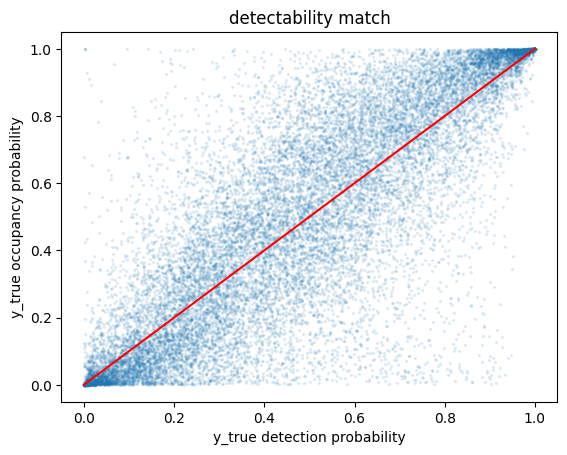

In [136]:
with torch.no_grad():
    out = model.forward(data.x_dict, data.edge_index_dict)
    p_hat = model.forward_p(out)
    psi_hat = model.forward_psi(out)


plt.scatter(
    df[[f'true_det_sp{i}' for i in range(n_sp)]].values.flatten(),
    p_hat.detach().numpy().flatten(), alpha=0.1, s=2
)
plt.plot([0,1], [0,1], color='red')
plt.title('detectability match')
plt.xlabel('y_true detection probability')
plt.ylabel('y_true occupancy probability')
plt.show()


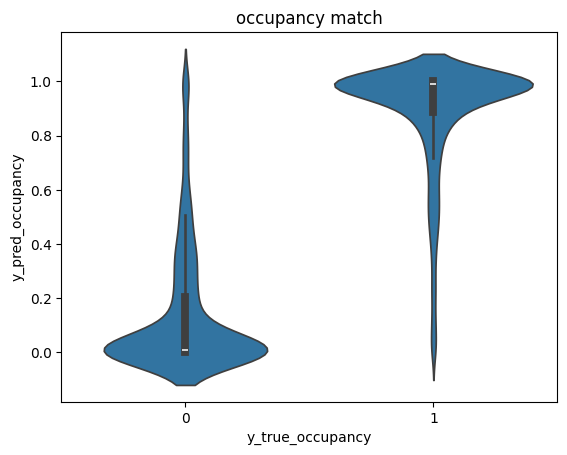

In [137]:
plotting_df = pd.DataFrame({
    'y_true_occupancy':df[['site', *[f'true_occ_sp{i}' for i in range(n_sp)]]].groupby('site').first().values.flatten(),
    'y_pred_occupancy':psi_hat.detach().numpy().flatten()
})

sns.violinplot(x=plotting_df['y_true_occupancy'], y=plotting_df['y_pred_occupancy'])
plt.title('occupancy match')
plt.show()


In [138]:
with torch.no_grad():
    res = model(data.x_dict, data.edge_index_dict)
    species_x  = res['species'] 
    
    trained_GAT = list(model.layers[0].hetero_conv.modules())[1][('species', 'influence', 'species')]

    edge_index_ss = data.edge_index_dict[('species','influence','species')]  # [2, E]

    _, (eidx, alpha) = trained_GAT(
        species_x,
        edge_index_ss,
        return_attention_weights=True
    )
    src, dst = eidx  # each of length E
    n_sp = species_x.size(0)
    G_hat = torch.zeros(n_sp, n_sp, device=alpha.device)
    G_hat[dst, src] = alpha.view(1,-1)
    
    G_hat = G_hat.detach().numpy()
    
mask = np.eye(n_sp)==0
G_hat_masked = G_hat[mask]
gamma_masked = gamma[mask]


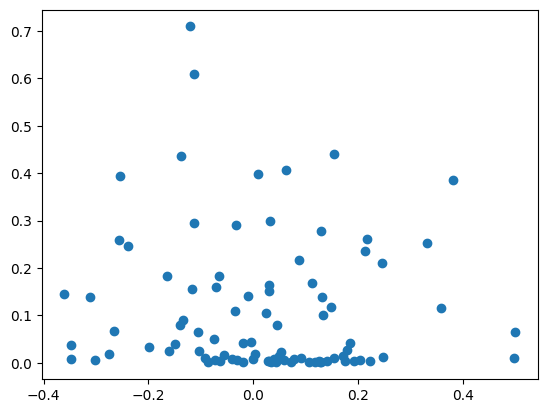

In [139]:
plt.scatter(
    gamma_masked.flatten(),
    G_hat_masked.flatten()
)

## Edge removal: sp1 -> sp2, sp1 <- sp2

In [140]:
new_edge_dict = data.edge_index_dict
new_edge_dict[('species', 'influence', 'species')] =\
    new_edge_dict[('species', 'influence', 'species')][:,
        ~(((new_edge_dict[('species', 'influence', 'species')][0,:]==0) & (new_edge_dict[('species', 'influence', 'species')][1,:]==1)) |\
        ((new_edge_dict[('species', 'influence', 'species')][0,:]==1) & (new_edge_dict[('species', 'influence', 'species')][1,:]==0)))
    ] # remove the edge between 01 and 10



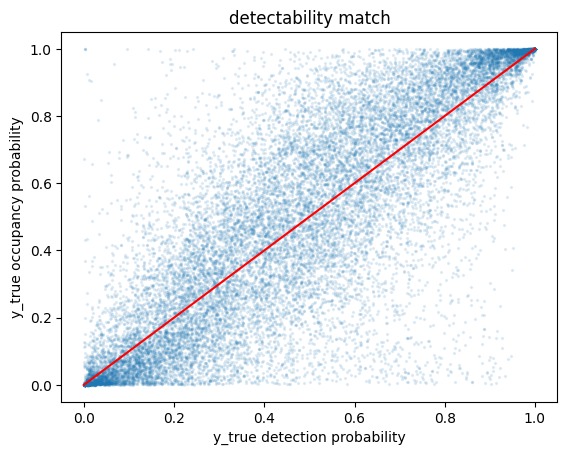

In [141]:
with torch.no_grad():
    out = model.forward(data.x_dict, new_edge_dict)
    p_hat = model.forward_p(out)
    psi_hat = model.forward_psi(out)
    
    out = model.forward(data.x_dict, data.edge_index_dict)
    p_hat_original = model.forward_p(out)
    psi_hat_original = model.forward_psi(out)

plt.scatter(
    df[[f'true_det_sp{i}' for i in range(n_sp)]].values.flatten(),
    p_hat.detach().numpy().flatten(), alpha=0.1, s=2
)
plt.plot([0,1], [0,1], color='red')
plt.title('detectability match')
plt.xlabel('y_true detection probability')
plt.ylabel('y_true occupancy probability')
plt.show()


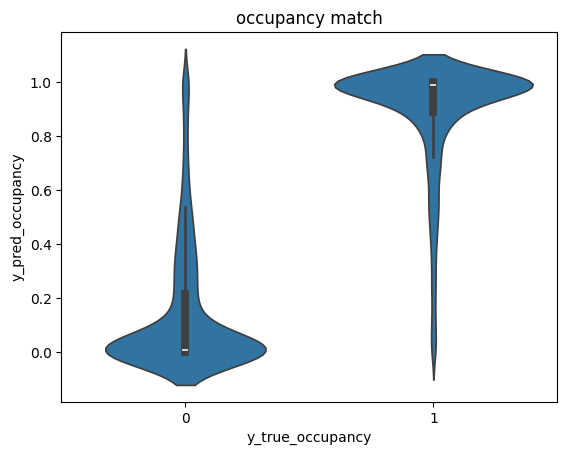

In [142]:
plotting_df = pd.DataFrame({
    'y_true_occupancy':df[['site', *[f'true_occ_sp{i}' for i in range(n_sp)]]].groupby('site').first().values.flatten(),
    'y_pred_occupancy':psi_hat.detach().numpy().flatten()
})

sns.violinplot(x=plotting_df['y_true_occupancy'], y=plotting_df['y_pred_occupancy'])
plt.title('occupancy match')
plt.show()


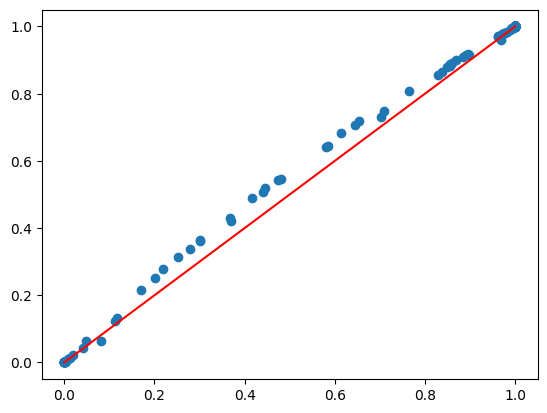

In [143]:
occ_ori = psi_hat_original.detach().numpy()[:,0] # species 0's occupancy at each site
occ_now = psi_hat.detach().numpy()[:,0] # species 0's occupancy at each site

plt.scatter(
    occ_ori,
    occ_now
)
plt.plot([0,1], [0,1], color='red')
plt.show()


The removal of 1 will make 1 more occupied, so they have a negative interaction?

In [146]:
gamma[0,1], gamma[1,0]
# (np.float64(-0.008866705219801286), np.float64(0.03432606558500756))
# so 1 -> 0

(np.float64(-0.008866705219801286), np.float64(0.03432606558500756))

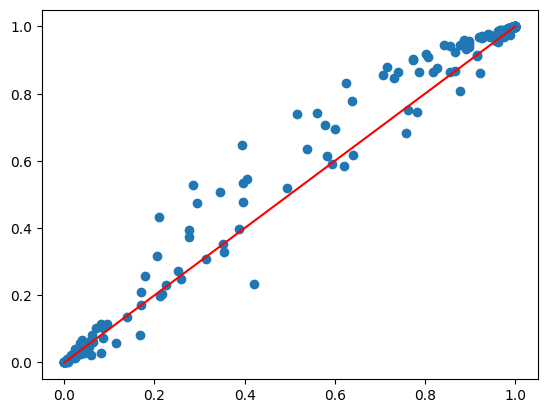

In [145]:
occ_ori = psi_hat_original.detach().numpy()[:,1] # species 1's occupancy at each site
occ_now = psi_hat.detach().numpy()[:,1] # species 1's occupancy at each site

plt.scatter(
    occ_ori,
    occ_now
)
plt.plot([0,1], [0,1], color='red')
plt.show()


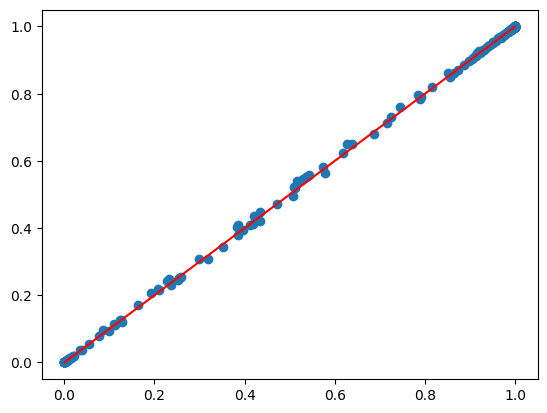

In [147]:
occ_ori = psi_hat_original.detach().numpy()[:,3] # species 1's occupancy at each site
occ_now = psi_hat.detach().numpy()[:,3] # species 1's occupancy at each site

plt.scatter(
    occ_ori,
    occ_now
)
plt.plot([0,1], [0,1], color='red')
plt.show()


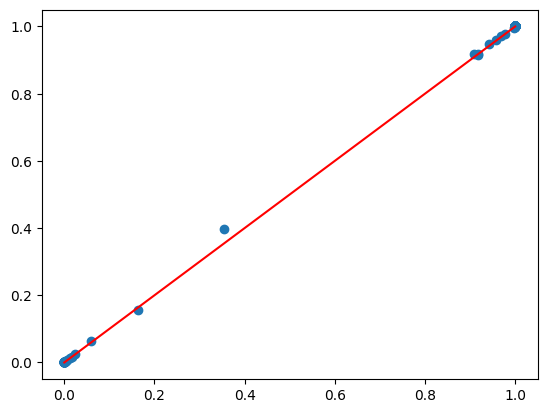

In [148]:
occ_ori = psi_hat_original.detach().numpy()[:,4] # species 1's occupancy at each site
occ_now = psi_hat.detach().numpy()[:,4] # species 1's occupancy at each site

plt.scatter(
    occ_ori,
    occ_now
)
plt.plot([0,1], [0,1], color='red')
plt.show()


## Node removal: sp1?

In [ ]:
new_edge_dict = data.edge_index_dict
new_edge_dict[('species', 'influence', 'species')] =\
    new_edge_dict[('species', 'influence', 'species')][:,
        ~(((new_edge_dict[('species', 'influence', 'species')][0,:]==0) & (new_edge_dict[('species', 'influence', 'species')][1,:]==1)) |\
        ((new_edge_dict[('species', 'influence', 'species')][0,:]==1) & (new_edge_dict[('species', 'influence', 'species')][1,:]==0)))
    ] # remove the edge between 01 and 10



In [ ]:
[]

{'site': tensor([[-6.1775e-02, -1.5657e+00],
         [-4.0181e+00, -3.2713e+00],
         [ 1.4242e+00, -1.3464e+00],
         [-7.6158e-01, -3.0885e+00],
         [-2.7237e+00, -5.2091e+00],
         [-1.9899e+00,  1.1436e+00],
         [ 4.4311e-01, -2.4135e+00],
         [-3.0791e+00, -4.5628e-01],
         [-1.8499e+00,  1.3404e-01],
         [-4.4754e-01, -3.1748e+00],
         [-2.3474e+00, -7.7270e-01],
         [-3.9569e+00,  4.9975e-02],
         [-1.9059e-01,  1.5409e-01],
         [-4.4300e+00, -3.0785e+00],
         [-1.7413e+00, -3.3158e+00],
         [-3.6886e+00,  6.8977e-01],
         [ 1.1515e+00, -1.2181e+00],
         [ 2.2871e+00, -3.9388e+00],
         [-2.8596e-01, -2.3492e+00],
         [-4.5538e+00, -2.9378e+00],
         [-3.5890e+00, -1.7252e-01],
         [-4.4668e-01, -1.9441e+00],
         [-1.0279e+00, -1.7251e+00],
         [-1.0123e+00, -2.8461e+00],
         [ 7.9143e-01,  6.1049e-01],
         [-3.4128e+00,  4.1313e+00],
         [ 1.8625e+00,  1.6806

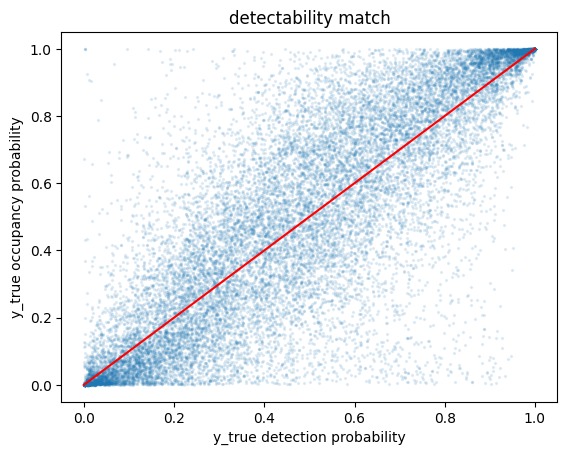

In [ ]:
with torch.no_grad():
    out = model.forward(data.x_dict, new_edge_dict)
    p_hat = model.forward_p(out)
    psi_hat = model.forward_psi(out)
    
    out = model.forward(data.x_dict, data.edge_index_dict)
    p_hat_original = model.forward_p(out)
    psi_hat_original = model.forward_psi(out)

plt.scatter(
    df[[f'true_det_sp{i}' for i in range(n_sp)]].values.flatten(),
    p_hat.detach().numpy().flatten(), alpha=0.1, s=2
)
plt.plot([0,1], [0,1], color='red')
plt.title('detectability match')
plt.xlabel('y_true detection probability')
plt.ylabel('y_true occupancy probability')
plt.show()


## Species parameters clustereing

In [149]:
with torch.no_grad():
    res = model(data.x_dict, data.edge_index_dict)


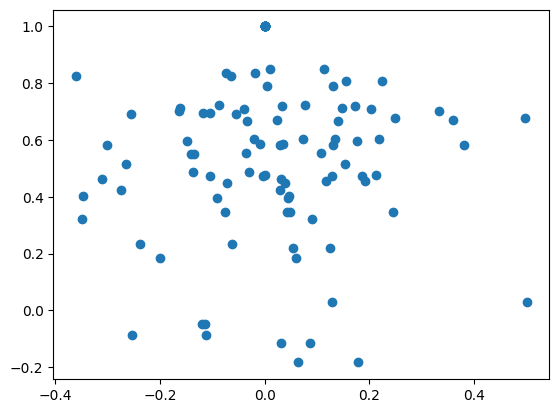

In [150]:
plt.scatter(
    gamma.flatten(),
    np.corrcoef(res['species'].detach().numpy(), rowvar=True).flatten()
)


In [ ]:
# with torch.no_grad():
#     res = model(data.x_dict, data.edge_index_dict)
#     gamma_flat = model.gamma_net(res['site'])                           # (n_site, S*S) should be a value [0, +inf)
#     gamma_site = gamma_flat.view(model.n_site, model.n_species, model.n_species)

# mask = np.eye(n_sp)==0
# gamma_masked = gamma[mask]
# gamma_hat_masked = gamma_site.mean(axis=0)[mask]

# plt.scatter(
#     gamma_masked,
#     gamma_hat_masked
# )

